In [4]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import joblib
import matplotlib.pyplot as plt



# Alleen train inladen
train_path = "../../data/data_train.csv" 
df = pd.read_csv(train_path, sep=",", decimal=".")
df['Seconds_Per_Call'] = df['Seconds of Use'] / df['Frequency of use'].replace(0,1)
df['SMS_per_Call'] = df['Frequency of SMS'] / df['Frequency of use'].replace(0,1)
df['Total_Activity'] = df['Frequency of use'] + df['Frequency of SMS']
df['Unique_Number_Ratio'] = df['Distinct Called Numbers'] / df['Frequency of use'].replace(0,1)
df['Usage_per_month'] = df['Seconds of Use'] / df['Subscription Length']
df['Complaints_per_Activity'] = df['Complaints'] / df['Total_Activity'].replace(0,1)


In [5]:
# Scheiden van target en input variabelen
target = "Churn"

X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape


((1995, 15), (1995,))

In [11]:
# Er is maar een categorische variabelen waar we OneHotEncoder op kunnen gebruiken namelijk Age group, 
# ookal is dit eigenlijk niet nodig omdat we ook een numerieke Age variabelen in de dataset hebben, maar de opdracht zei dat het moest...
cat_cols = ["Age Group"]
num_cols = [c for c in X.columns if c not in cat_cols]

In [24]:
# ColumnTransformer voor OneHotEncoder en StandardScaler voor de overige numerieke variabelen
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [28]:
# Hier maken we de pipline aan 
prep_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)
])
prep_pipeline

,steps,"[('preprocessing', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# Hier stoppen we X (input variabelen) in onze pipeline en leert de pipeline hoe hij deze moet schalen/encoden
X_prepared = prep_pipeline.fit_transform(X)
X_prepared.shape

array([[-0.91404633, -0.29125369,  0.76399641, ...,  1.        ,
         0.        ,  0.        ],
       [-0.36267512, -0.29125369, -1.42872594, ...,  0.        ,
         0.        ,  0.        ],
       [-1.05188914, -0.29125369,  0.64858997, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.8779101 , -0.29125369, -0.39006798, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.18869609, -0.29125369, -0.50547442, ...,  0.        ,
         0.        ,  1.        ],
       [-0.22483232, -0.29125369, -3.04441609, ...,  1.        ,
         0.        ,  0.        ]])

We hebben nu 13 kolommen omdat door OneHotEncoder de categorische Age is omgezet naar 5 binaire kolommen.

In [26]:
# Fase 4: Nu voegen we Logistic Regression toe aan onze pipeline
model_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(random_state=2026))
])

model_pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
# Fit het model
model_pipeline.fit(X, y)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# De pipeline opslaan als bestand
joblib.dump(model_pipeline, "../../data/model_pipeline.joblib")
# Model weer inladen:
# model_pipeline = joblib.load("../../data/model_pipeline.joblib")

['../../data/model_pipeline.joblib']

Nu hebben we het modelleren afgerond.
De volgende stap is ons model beoordelen op de trainingsdata

In [7]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from io import BytesIO
import base64

def display_executive_model_evaluation(y_true, y_pred, class_names=None):

    # -------------------------
    # Label mapping
    # -------------------------
    unique_labels = sorted(list(set(y_true)))

    if class_names:
        if len(class_names) != len(unique_labels):
            raise ValueError("class_names moet dezelfde lengte hebben als unieke labels.")
        label_map = dict(zip(unique_labels, class_names))
        y_true = [label_map[y] for y in y_true]
        y_pred = [label_map[y] for y in y_pred]
        used_labels = class_names
    else:
        used_labels = [str(l) for l in unique_labels]

    # -------------------------
    # Metrics
    # -------------------------
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    macro = report.get("macro avg", {})
    weighted = report.get("weighted avg", {})

    class_metrics = []
    for cls in used_labels:
        c = report.get(cls, {"precision":0,"recall":0,"f1-score":0,"support":0})
        class_metrics.append({
            "label": cls,
            "precision": c["precision"],
            "recall": c["recall"],
            "f1": c["f1-score"],
            "support": int(c["support"])
        })

    # -------------------------
    # Hover explanations
    # -------------------------
    hover = {
        "accuracy": "Percentage correcte voorspellingen = juiste voorspellingen / totaal aantal observaties.",
        "macro": "Macro gemiddelde: gelijke weging per klasse, ongeacht grootte.",
        "weighted": "Weighted gemiddelde: gewogen naar aantal observaties per klasse.",
        "precision": "Precision = TP / (TP + FP)",
        "recall": "Recall = TP / (TP + FN)",
        "f1": "F1-score = Harmonic mean van Precision en Recall.",
        "support": "Aantal observaties in deze klasse."
    }

    def info_icon(text):
        return f'<span style="font-size:12px; color:#9CA3AF; cursor:help; margin-left:4px;" title="{text}">ⓘ</span>'

    # -------------------------
    # HTML REPORT
    # -------------------------
    html = f"""
    <div style="
        font-family:'Segoe UI', Arial, sans-serif;
        max-width:1000px;
        padding:30px;
        color:#111827;
        background:#FFFFFF;
        border-radius:8px;
        box-shadow: 0 8px 20px rgba(0,0,0,0.1);  /* Extra premium schaduw */
    ">

        <div style="font-size:28px; font-weight:600; margin-bottom:35px;">
            Model Performance Summary
        </div>

        <div style="display:flex; gap:80px; margin-bottom:45px;">

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Accuracy {info_icon(hover["accuracy"])}
                </div>
                <div style="font-size:44px; font-weight:600; margin-top:4px;">
                    {acc:.2%}
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Macro Average {info_icon(hover["macro"])}
                </div>
                <div style="margin-top:6px; font-size:16px; line-height:1.6;">
                    Precision: <b>{macro.get("precision",0):.2f}</b><br>
                    Recall: <b>{macro.get("recall",0):.2f}</b><br>
                    F1-score: <b>{macro.get("f1-score",0):.2f}</b>
                </div>
            </div>

            <div>
                <div style="font-size:13px; color:#6B7280;">
                    Weighted Average {info_icon(hover["weighted"])}
                </div>
                <div style="margin-top:6px; font-size:16px; line-height:1.6;">
                    Precision: <b>{weighted.get("precision",0):.2f}</b><br>
                    Recall: <b>{weighted.get("recall",0):.2f}</b><br>
                    F1-score: <b>{weighted.get("f1-score",0):.2f}</b>
                </div>
            </div>

        </div>

        <div style="height:1px; background:#E5E7EB; margin-bottom:40px;"></div>

        <div style="font-size:20px; font-weight:600; margin-bottom:20px;">
            Per Class Performance
        </div>

        <table style="width:100%; border-collapse:collapse; font-size:15px;">
            <thead>
                <tr style="text-align:left; border-bottom:2px solid #111827;">
                    <th style="padding:12px 0;">Class</th>
                    <th>Precision {info_icon(hover["precision"])}</th>
                    <th>Recall {info_icon(hover["recall"])}</th>
                    <th>F1-score {info_icon(hover["f1"])}</th>
                    <th>Support {info_icon(hover["support"])}</th>
                </tr>
            </thead>
            <tbody>
    """

    for c in class_metrics:
        html += f"""
            <tr style="border-bottom:1px solid #E5E7EB;">
                <td style="padding:12px 0;">{c['label']}</td>
                <td><b>{c['precision']:.2f}</b></td>
                <td><b>{c['recall']:.2f}</b></td>
                <td><b>{c['f1']:.2f}</b></td>
                <td>{c['support']}</td>
            </tr>
        """

    html += """
            </tbody>
        </table>

        <div style="height:1px; background:#E5E7EB; margin:30px 0;"></div>

        <div style="font-size:20px; font-weight:600; margin-bottom:0px;">
            Confusion Matrix
        </div>

        <div id="confusion-matrix-container" style="width:100%; text-align:left; padding:0px 0;">
            <img src="data:image/png;base64,{confusion_matrix_img}" alt="Confusion Matrix" width="70%" />
        </div>

    </div>
    """

    # -------------------------
    # CONFUSION MATRIX
    # -------------------------
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    percent = cm / total * 100

    sns.set_style("white")
    plt.rcParams.update({"font.family": "DejaVu Sans"})

    fig, ax = plt.subplots(figsize=(9, 6))

    cmap = sns.light_palette("#1f4e79", as_cmap=True)

    heatmap = sns.heatmap(
        cm,
        annot=False,
        cmap=cmap,
        cbar=True,
        linewidths=0.6,
        linecolor="#ECECEC",
        square=True,
        ax=ax
    )

    threshold = cm.max() / 2

    labels_matrix = [["True Negative", "False Positive"],
                    ["False Negative", "True Positive"]]

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "#2b2b2b"

            ax.text(j + 0.5, i + 0.30,
                    labels_matrix[i][j],
                    ha='center', va='center',
                    fontsize=10,
                    color=color,
                    alpha=0.9)
            
            # Groot getal in het midden
            ax.text(j + 0.5, i + 0.60,
                    f"{cm[i,j]:,}",
                    ha='center', va='center',
                    fontsize=26,
                    fontweight='bold',
                    color=color)
            
            # Percentage onderin
            ax.text(j + 0.5, i + 0.85,
                    f"{percent[i,j]:.1f}%",
                    ha='center', va='center',
                    fontsize=11,
                    color=color,
                    alpha=0.85)

    fig.text(0.93, 0.02,
            f"Total samples: {total:,}",
            ha="right",
            va="bottom",
            fontsize=10,
            color="#6B7280")
    # Bovenkant van de afbeelding afsnijden (croppen)
    fig.subplots_adjust(top=0.95)  # Verkort de bovenkant (door de top margin in te stellen)


    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("Actual", fontsize=12)

    ax.set_xticklabels(used_labels)
    ax.set_yticklabels(used_labels, rotation=0)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Sla de plot op in geheugen
    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)

    # Zet het om naar base64
    confusion_matrix_img = base64.b64encode(img_buffer.read()).decode('utf-8')

    # Pas de HTML aan
    html = html.format(confusion_matrix_img=confusion_matrix_img)

    plt.close()

    # Display de volledige HTML
    display(HTML(html))

Class,Precision ⓘ,Recall ⓘ,F1-score ⓘ,Support ⓘ
Niet Opgezegd,0.90,0.99,0.94,1660
Opgezegd,0.92,0.43,0.58,335

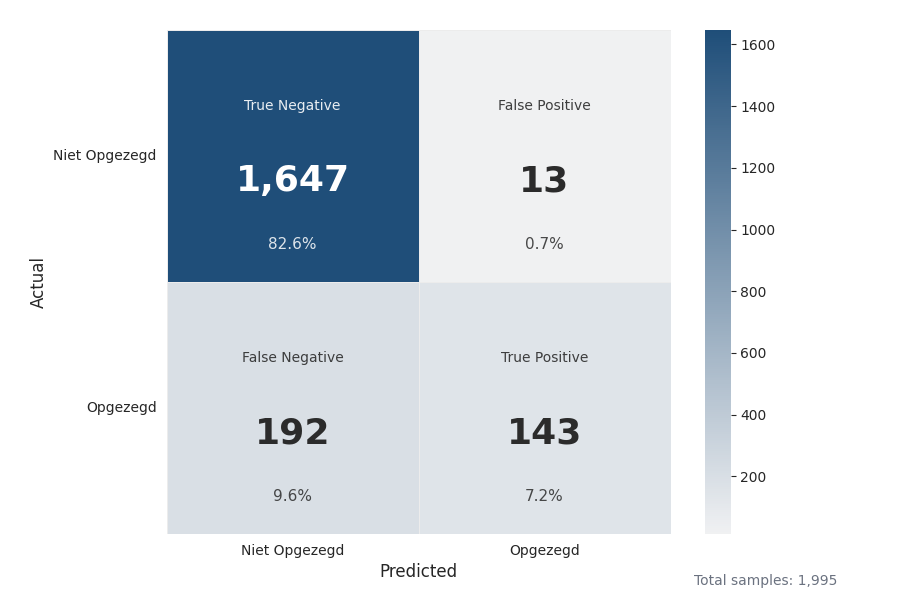

In [8]:
import joblib

model_pipeline = joblib.load("../../data/model_pipeline.joblib")
class_names = ["Niet Opgezegd", "Opgezegd"]
y_pred = model_pipeline.predict(X)

display_executive_model_evaluation(
    y,
    y_pred,
    class_names=class_names
)

Accuracy: 0.904
Confusion matrix:
[[1646   14]
 [ 177  158]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      1660
           1       0.92      0.47      0.62       335

    accuracy                           0.90      1995
   macro avg       0.91      0.73      0.78      1995
weighted avg       0.91      0.90      0.89      1995

ROC-AUC: 0.930


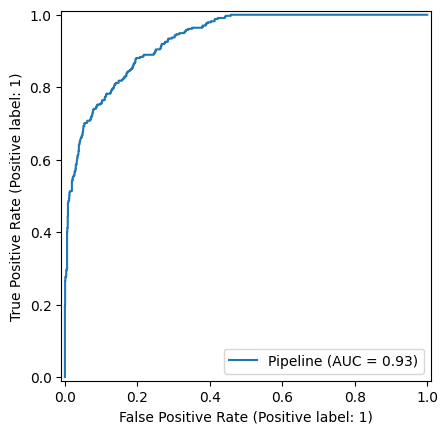

In [41]:
# Voorspel de kans op Churn
#proba = model_pipeline.predict_proba(X)[:, 1]
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

y_pred = model_pipeline.predict(X)
y_prob = model_pipeline.predict_proba(X)[:,1]  # kans dat Churn = 1


# 2️⃣ Accuracy
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.3f}")

# 3️⃣ Confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion matrix:")
print(cm)

# 4️⃣ Classification report
print("Classification report:")
print(classification_report(y, y_pred))

# 5️⃣ ROC-AUC
roc_auc = roc_auc_score(y, y_prob)
print(f"ROC-AUC: {roc_auc:.3f}")

# 6️⃣ ROC-curve plotten
RocCurveDisplay.from_estimator(model_pipeline, X, y)
plt.show()

In [31]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = rf.predict(X)
y_proba = rf.predict_proba(X)[:,1]

print(classification_report(y, y_pred))
print("ROC-AUC:", roc_auc_score(y, y_proba))
cm = confusion_matrix(y, y_pred)
print("Confusion matrix:")
print(cm)


              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1660
           1       0.89      0.66      0.76       335

    accuracy                           0.93      1995
   macro avg       0.91      0.82      0.86      1995
weighted avg       0.93      0.93      0.92      1995

ROC-AUC: 0.9670733680992627
Confusion matrix:
[[1634   26]
 [ 115  220]]


In [34]:
import pandas as pd
import plotly.express as px

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

fig = px.bar(
    feat_imp,
    x='Feature',
    y='Importance',
    title='Feature Importance Random Forest',
    width=1200,
    height=400
)
fig.update_layout(template='simple_white')
fig.show()
